In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch as th
import matplotlib.pyplot as plt

sys.path.append('..')
import alntools as aln

In [2]:
dbpath = "/home/nfs/kkaminski/PLMBLST/ecod70db_20220902"
data = pd.read_csv(dbpath + '.csv')
seq1idx = 100
seq2idx = 2000

seq1 = data.iloc[seq1idx].T.sequence
seq2 = data.iloc[seq2idx].T.sequence
emb1 = th.load(os.path.join(dbpath, f'{seq1idx}.emb')).float()
emb2 = th.load(os.path.join(dbpath, f'{seq2idx}.emb')).float()

densitymap = aln.density.embedding_similarity(emb1, emb2)
# convert to numpy array
densitymap = densitymap.cpu().numpy()
# find all alignment possible paths (traceback from borders)
paths, scoremap = aln.alignment.gather_all_paths(densitymap, norm='row', with_scores=True)
# score those paths
paths_all = [p - 1 for p in paths]
mask_all = aln.prepare.mask_like(densitymap, paths_all)
results = aln.prepare.search_paths(densitymap, paths=paths, as_df=True)
results['i'] = 'dump'

# remove redundant hits
results = aln.postprocess.filter_result_dataframe(results)
mask = aln.prepare.mask_like(densitymap, results.indices)

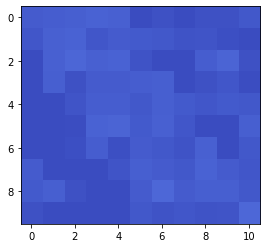

In [6]:
kernel_size = 30
if emb1.shape[1] == 1024:
    emb1 = th.nn.functional.avg_pool1d(emb1.unsqueeze(0), 8).squeeze()
if emb2.shape[1] == 1024:
    emb2 = th.nn.functional.avg_pool1d(emb2.unsqueeze(0), 8).squeeze()
emb_as_filters = aln.density.local.sequence_to_filters(emb1, kernel_size=kernel_size, stride=2, with_padding=False)
density_chunk = aln.density.local.single_process(emb_as_filters, emb2, stride=3)

plt.imshow(density_chunk, cmap='coolwarm', vmin=0, vmax=1)
plt.savefig('img/chunkdens.png', dpi=300)

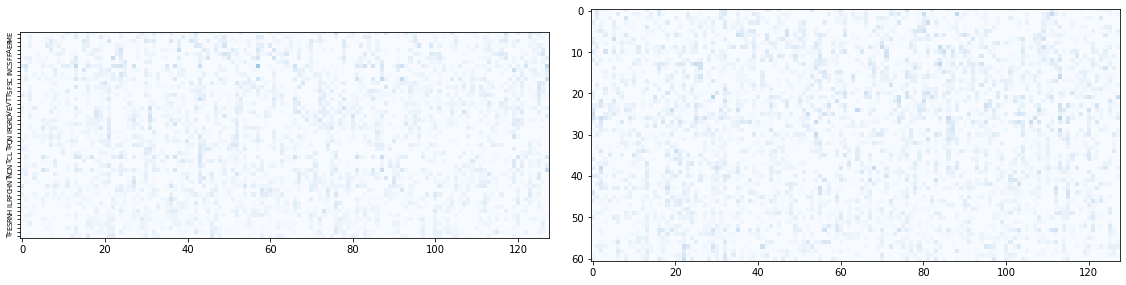

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 16))
kwargs = {'vmin' : 0, 'vmax' : 1, 'cmap' : 'Blues', 'aspect' : 'auto'}
fig.tight_layout()
ax[0].imshow(emb1.squeeze(),  **kwargs)
ax[0].set_yticks(list(range(len(seq1))), list(seq1), rotation='vertical', fontsize=7)
ax[1].imshow(emb2.squeeze(),  **kwargs)
#for axi in ax:
#    axi.axis('off')
fig.savefig('img/embs.png', dpi=300)

IndexError: index 10 is out of bounds for dimension 0 with size 10

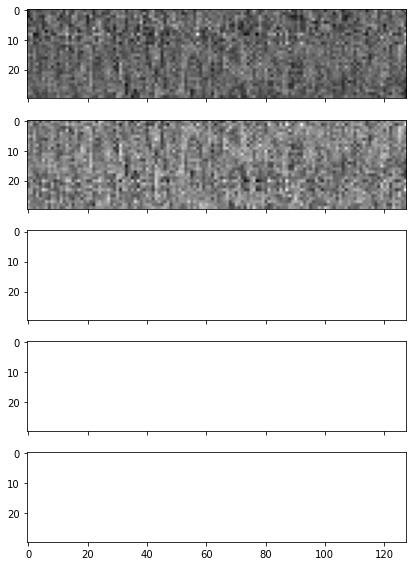

In [8]:
fig, ax = plt.subplots(5, 1, figsize=(6, 8), sharex = True, sharey = True)
cmap = 'gray'
fig.tight_layout()
ax[0].imshow(emb_as_filters[0].squeeze(), cmap=cmap)
ax[1].imshow(emb_as_filters[5].squeeze(), cmap=cmap)
ax[2].imshow(emb_as_filters[10].squeeze(), cmap=cmap)
ax[3].imshow(emb_as_filters[15].squeeze(), cmap=cmap)
ax[4].imshow(emb_as_filters[20].squeeze(), cmap=cmap)
for axi in ax:
    axi.axis('off')
fig.savefig('img/filters.png', dpi=300)

(0.0, 1.0, 0.0, 1.0)

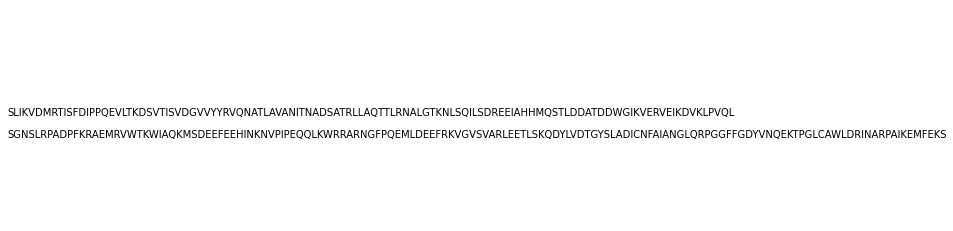

In [ ]:
plt.plot()
plt.text(0,0.5,seq1)
plt.text(0, 0.4, seq2)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

(-0.5, 113.5, 142.5, -0.5)

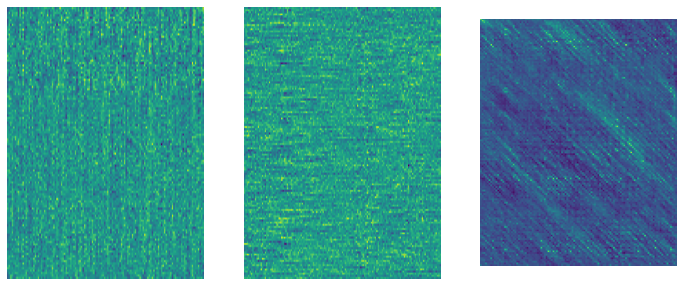

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(emb1, aspect='auto')
ax[0].axis('off')
ax[1].imshow(emb2.T, aspect='auto')
ax[1].axis('off')
ax[2].imshow(densitymap)
ax[2].axis('off')

(-0.5, 114.5, 143.5, -0.5)

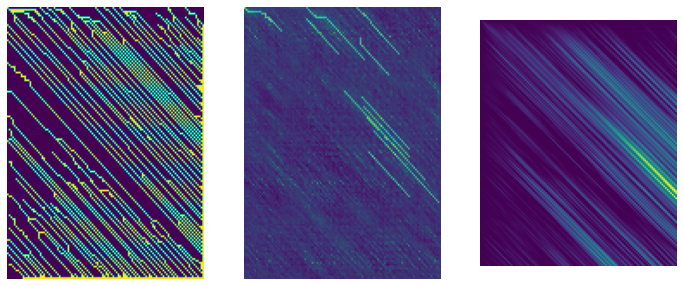

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(mask_all, aspect='auto')
ax[0].axis('off')
ax[1].imshow(densitymap)
ax[1].imshow(mask, aspect='auto', alpha=0.4)
ax[1].axis('off')

ax[2].imshow(scoremap)
ax[2].axis('off')

In [ ]:
coldict = {'orange' : "Oranges",
           'green' : "Greens",
           'red' : 'Reds'
           }

(-0.5, 113.5, 142.5, -0.5)

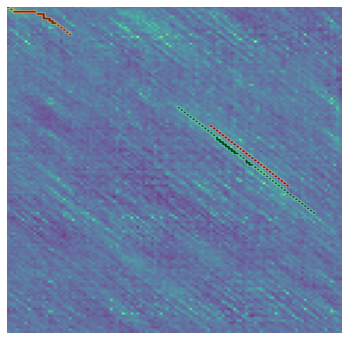

In [ ]:
aln_indices = results.indices.tolist()


aln_list = []
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(densitymap, alpha=0.8)
for i, (col, cmap) in enumerate(coldict.items()):
    mask_single = aln.prepare.mask_like(densitymap, [aln_indices[i]])
    ax.imshow(mask_single, aspect='auto', alpha=mask_single, cmap=cmap)
    string = aln.draw_alignment(aln_indices[i], seq1, seq2, output=True)
    aln_list.append(string)
ax.axis('off')


In [ ]:
from IPython.display import display, HTML
HEADER = """<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
  color: blue;
}
th, td {
  padding-top: 1px;
  padding-bottom: 1px;
  padding-left: 1px;
  padding-right: 1px;
}
</style>
</head>"""

string = string.split('\n')

string_new = ''

for line in string:
    line = [f'<th>{letter}<th>' for letter in line]
    line = ''.join(line)
    line = '<tr>' + line + '<tr>'
    string_new += line
string_new  = f'<body><table>{string_new}</table></body>'

In [ ]:
HTML(header + string_new)

NameError: name 'header' is not defined

In [ ]:
def format_table(string, color):
    header = """<html>
    <head>
    <style>
    table, th, td {
    border: 1px solid black;
    border-collapse: collapse;
    color: %s;
    }
    th, td {
    padding-top: 1px;
    padding-bottom: 1px;
    padding-left: 1px;
    padding-right: 1px;
    }
    </style>
    </head>""" % color

    string = string.split('\n')

    string_new = ''

    for line in string:
        line = [f'<th>{letter}<th>' for letter in line]
        line = ''.join(line)
        line = '<tr>' + line + '<tr>'
        string_new += line
    string_new  = f'<body><table>{string_new}</table></body>'
    return string_new